### DS 6003 - Spark Assignment
#### Name: Charu Rawat , Computing ID : cr4zy

#### Import necessary modules/packages

In [1]:
import pyspark
from os import listdir
from os.path import isfile, join
import boto3
import pandas as pd
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType
import pyspark.sql.functions as sf

#### Initialize the spark environment

In [2]:
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)
sc

<SparkContext master=local appName=odl>

In [3]:
sqlc

#### Read into spark dataframe from csv

In [4]:
role = get_execution_role()
bucket='odl-spark19spds6003-001'
data_key = 'cr4zy/admissions_data.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
#pd.read_csv(data_location)

In [5]:
df = sqlc.createDataFrame(pd.read_csv(data_location))
df

DataFrame[ID: bigint, GRE: bigint, TOEFL: bigint, UniRating: bigint, SOP: double, LOR: double, CGPA: double, Research: bigint, Admission: double]

#### Write parque to s3

In [6]:
parquetPath = '/home/ec2-user/SageMaker/cr4zy/parquet_tmp'
df.write.parquet(parquetPath)

In [7]:
# prep list of files to transfer
files = [f for f in listdir(parquetPath) if isfile(join(parquetPath, f))]

s3 = boto3.resource('s3')
for f in files:
    #print('copying {} to {}'.format(parquetPath+'/'+f,"sample_data/"+f))
    s3.Bucket(bucket).upload_file(parquetPath+'/'+f, "cr4zy/"+f)

#### Make dataframe from parquet

In [8]:
# write to spark df
df = sqlc.read.parquet(parquetPath)
df

DataFrame[ID: bigint, GRE: bigint, TOEFL: bigint, UniRating: bigint, SOP: double, LOR: double, CGPA: double, Research: bigint, Admission: double]

In [9]:
display(df)

DataFrame[ID: bigint, GRE: bigint, TOEFL: bigint, UniRating: bigint, SOP: double, LOR: double, CGPA: double, Research: bigint, Admission: double]

In [10]:
df.printSchema()

root
 |-- ID: long (nullable = true)
 |-- GRE: long (nullable = true)
 |-- TOEFL: long (nullable = true)
 |-- UniRating: long (nullable = true)
 |-- SOP: double (nullable = true)
 |-- LOR: double (nullable = true)
 |-- CGPA: double (nullable = true)
 |-- Research: long (nullable = true)
 |-- Admission: double (nullable = true)



#### Correlation between variables

In [11]:
# Dependent variable is Admission (Chance of admit)
print("Pearson's r(GRE,TOEFL) = {}".format(df.corr("GRE", "TOEFL")))
print("Pearson's r(SOP,LOR) = {}".format(df.corr("SOP", "LOR")))
print("Pearson's r(CGPA,Admission) = {}".format(df.corr("CGPA", "Admission")))
print("Pearson's r(GRE,Admission) = {}".format(df.corr("GRE", "Admission")))
print("Pearson's r(SOP,Admission) = {}".format(df.corr("SOP", "Admission")))

Pearson's r(GRE,TOEFL) = 0.8359768030143965
Pearson's r(SOP,LOR) = 0.7295925366175839
Pearson's r(CGPA,Admission) = 0.8732890993553003
Pearson's r(GRE,Admission) = 0.8026104595903504
Pearson's r(SOP,Admission) = 0.6757318583886724


#### Select  features for analysis

In [12]:
df = df.select("GRE","TOEFL","SOP","LOR","CGPA","Admission")

#### Model Building

In [13]:
# create train/test sets
seed = 42
(testDF, trainingDF) = df.randomSplit((0.40, 0.60), seed=seed)
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 252, test set N = 148


#### Vectorization

In [14]:
from pyspark.ml.linalg import Vectors, VectorUDT # nb: bad form, done for pedagogy

In [15]:
#vectorization
# make a user defined function (udf)
sqlc.registerFunction("oneElementVec", lambda d: Vectors.dense([d]), returnType=VectorUDT())

# vectorize the data frames
trainingDF = trainingDF.selectExpr("Admission", "oneElementVec(GRE) as GRE","oneElementVec(TOEFL) as TOEFL" ,
                                   "oneElementVec(SOP) as SOP","oneElementVec(LOR) as LOR","oneElementVec(CGPA) as CGPA"                                  )
testDF = testDF.selectExpr("Admission", "oneElementVec(GRE) as GRE","oneElementVec(TOEFL) as TOEFL" ,
                                   "oneElementVec(SOP) as SOP","oneElementVec(LOR) as LOR","oneElementVec(CGPA) as CGPA")
print(testDF.orderBy(testDF.Admission.desc()).limit(5))

DataFrame[Admission: double, GRE: vector, TOEFL: vector, SOP: vector, LOR: vector, CGPA: vector]


In [16]:
# rename to make ML engine happy
trainingDF = trainingDF.withColumnRenamed("Admission", "label")
testDF = testDF.withColumnRenamed("Admission", "label")

In [17]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['GRE', 'TOEFL' ,'SOP', 'LOR', 'CGPA'], outputCol = 'features')
trainingDF = vectorAssembler.transform(trainingDF)
trainingDF = trainingDF.select(['features', 'label'])
#trainingDF.show(3)

testDF = vectorAssembler.transform(testDF)
testDF = testDF.select(['features', 'label'])
testDF.show(3)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[295.0,96.0,1.5,2...| 0.47|
|[295.0,99.0,2.5,3...| 0.57|
|[295.0,101.0,2.5,...| 0.69|
+--------------------+-----+
only showing top 3 rows



#### Fitting a linear regression model
1. Train
2. Predict
3. Evaluate

In [18]:
from pyspark.ml.regression import LinearRegression, LinearRegressionModel

lr = LinearRegression()
lrModel = lr.fit(trainingDF)

In [19]:
trainingDF.take(5)

[Row(features=DenseVector([290.0, 100.0, 1.5, 2.0, 7.56]), label=0.47),
 Row(features=DenseVector([290.0, 104.0, 2.0, 2.5, 7.46]), label=0.45),
 Row(features=DenseVector([293.0, 97.0, 2.0, 4.0, 7.8]), label=0.64),
 Row(features=DenseVector([294.0, 93.0, 1.5, 2.0, 7.36]), label=0.46),
 Row(features=DenseVector([294.0, 95.0, 1.5, 1.5, 7.64]), label=0.49)]

In [20]:
# We are now going to transform our test set to get predictions. 
# It will append a prediction column to testDF in the new dataframe predictionsAndLabelsDF.
predictionsAndLabelsDF = lrModel.transform(testDF)
print(predictionsAndLabelsDF.orderBy(predictionsAndLabelsDF.label.desc()))

DataFrame[features: vector, label: double, prediction: double]


#### Visualization of model fit

In [21]:
# calculate residuals
predictionsAndLabelsDF = predictionsAndLabelsDF.withColumn('residuals', predictionsAndLabelsDF.prediction-predictionsAndLabelsDF.label)
#predictionsAndLabelsDF.show()
pdf = predictionsAndLabelsDF.toPandas()
pdf.head()

,features,label,prediction,residuals
0,"[295.0, 96.0, 1.5, 2.0, 7.34]",0.47,0.446536,-0.023464
1,"[295.0, 99.0, 2.5, 3.0, 7.65]",0.57,0.522928,-0.047072
2,"[295.0, 101.0, 2.5, 2.0, 7.86]",0.69,0.531845,-0.158155
3,"[296.0, 97.0, 1.5, 2.0, 7.8]",0.49,0.514442,0.024442
4,"[296.0, 99.0, 2.5, 2.5, 8.03]",0.61,0.564261,-0.045739


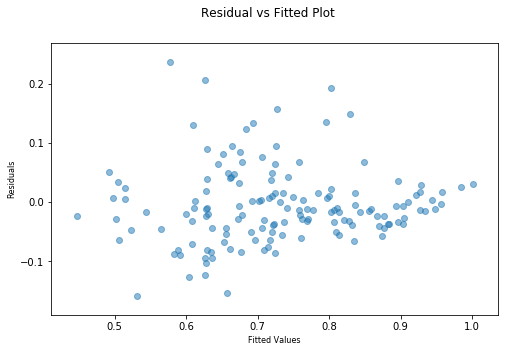

In [23]:
import matplotlib.pyplot as plt

x = pdf['prediction']
y = pdf['residuals']

fig = plt.figure(figsize=(8,5))
plt.scatter(x, y, alpha=0.5)
# format plots
fig.suptitle('Residual vs Fitted Plot', fontsize=12)
plt.xlabel('Fitted Values', fontsize=8)
plt.ylabel('Residuals', fontsize=8)

plt.show()

#### Model Evaluation

In [24]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator()
print(eval.explainParams())

labelCol: label column name. (default: label)
metricName: metric name in evaluation - one of:
                       rmse - root mean squared error (default)
                       mse - mean squared error
                       r2 - r^2 metric
                       mae - mean absolute error. (default: rmse)
predictionCol: prediction column name. (default: prediction)


In [25]:
type(eval)

pyspark.ml.evaluation.RegressionEvaluator

In [26]:
print("RMSE: %g" % eval.setMetricName("rmse").evaluate(predictionsAndLabelsDF))
print("R-Square: %g" %  eval.setMetricName("r2").evaluate(predictionsAndLabelsDF))
print("Mean Square Error: %g" % eval.setMetricName("mse").evaluate(predictionsAndLabelsDF))

RMSE: 0.0643891
R-Square: 0.762574
Mean Square Error: 0.00414595
